JPX is hosting this competition and is supported by AI technology company AlpacaJapan Co.,Ltd.

This competition will compare your models against real future returns after the training phase is complete. The competition will involve building portfolios from the stocks eligible for predictions (around 2,000 stocks). Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks.

In this notebook I will be doing some basic EDA and some feature creation to feed into high depth XGBoost decission trees.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
import jpx_tokyo_market_prediction
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import gc
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

Loading the training files, suppliment files and the file contais list of all the stocks.

In [2]:
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
supplemental_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
testprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")
teststockprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv")

Check the basic information about the files loaded into dataframes

In [3]:
supplemental_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229958 entries, 0 to 229957
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RowId             229958 non-null  object 
 1   Date              229958 non-null  object 
 2   SecuritiesCode    229958 non-null  int64  
 3   Open              229252 non-null  float64
 4   High              229252 non-null  float64
 5   Low               229252 non-null  float64
 6   Close             229252 non-null  float64
 7   Volume            229958 non-null  int64  
 8   AdjustmentFactor  229958 non-null  float64
 9   ExpectedDividend  2011 non-null    float64
 10  SupervisionFlag   229958 non-null  bool   
 11  Target            229952 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 19.5+ MB


In [4]:
supplemental_prices['Date'].unique()

array(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
       '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
       '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
       '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-27',
       '2021-12-28', '2021-12-29', '2021-12-30', '2022-01-04',
       '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-11',
       '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
       '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
       '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
       '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02',
       '2022-02-03', '2022-02-04', '2022-02-07', '2022-02-08',
       '2022-02-09', '2022-02-10', '2022-02-14', '2022-02-15',
       '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-21',
       '2022-02-22', '2022-02-24', '2022-02-25', '2022-02-28',
       '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
       '2022-03-07', '2022-03-08', '2022-03-09', '2022-

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [6]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          4417 non-null   int64  
 1   EffectiveDate           4417 non-null   int64  
 2   Name                    4417 non-null   object 
 3   Section/Products        4417 non-null   object 
 4   NewMarketSegment        3772 non-null   object 
 5   33SectorCode            4417 non-null   object 
 6   33SectorName            4417 non-null   object 
 7   17SectorCode            4417 non-null   object 
 8   17SectorName            4417 non-null   object 
 9   NewIndexSeriesSizeCode  4417 non-null   object 
 10  NewIndexSeriesSize      4417 non-null   object 
 11  TradeDate               4121 non-null   float64
 12  Close                   4121 non-null   float64
 13  IssuedShares            4121 non-null   float64
 14  MarketCapitalization    4121 non-null   

In [7]:
stock_list.head(2)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False


Append the secondary prices and suppliment prices

In [8]:
prices=prices.append(sprices,ignore_index=True)
prices=prices.append(supplemental_prices,ignore_index=True)
prices=prices.append(supplemental_sprices,ignore_index=True)
prices=prices.drop(['RowId','ExpectedDividend'],axis=1)
prices=prices.dropna()

In [9]:
prices.tail(5)

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
5189763,2022-05-27,9980,111.0,111.0,110.0,111.0,88600,1.0,False,0.000000
5189764,2022-05-27,9986,1973.0,1975.0,1956.0,1975.0,2300,1.0,False,-0.008920
5189765,2022-05-27,9995,408.0,411.0,408.0,411.0,24500,1.0,False,-0.002427
5189766,2022-05-27,9996,1256.0,1256.0,1248.0,1248.0,1200,1.0,False,0.003252
5189767,2022-05-27,25935,1862.0,1865.0,1855.0,1857.0,8100,1.0,False,0.000000


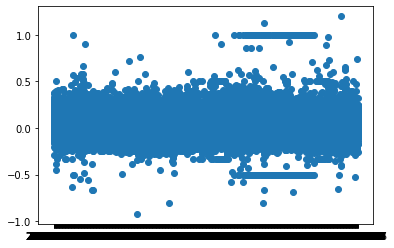

In [10]:
plt.scatter(prices['Date'],prices['Target'])

Separate train and test data sets

In [11]:
prices['DateValue']=prices['Date'].str.replace('-','')
xprices=prices[prices['DateValue']<'20220401']
xprices=xprices.drop(['DateValue'],axis=1)
yprices=prices[prices['DateValue']>='20220401']
yprices=yprices.drop(['DateValue'],axis=1)

In [12]:
xprices.count()

Date                4932293
SecuritiesCode      4932293
Open                4932293
High                4932293
Low                 4932293
Close               4932293
Volume              4932293
AdjustmentFactor    4932293
SupervisionFlag     4932293
Target              4932293
dtype: int64

In [13]:
yprices.count()

Date                147892
SecuritiesCode      147892
Open                147892
High                147892
Low                 147892
Close               147892
Volume              147892
AdjustmentFactor    147892
SupervisionFlag     147892
Target              147892
dtype: int64

In [14]:
gc.collect()

101

pop the target values into another dataframe

In [15]:
y_train=xprices.pop('Target')
y_test=yprices.pop('Target')
X_train=xprices
X_test=yprices

In [16]:
X_train.count()

Date                4932293
SecuritiesCode      4932293
Open                4932293
High                4932293
Low                 4932293
Close               4932293
Volume              4932293
AdjustmentFactor    4932293
SupervisionFlag     4932293
dtype: int64

In [17]:
del prices
del xprices
del yprices

feature engineering

In [18]:
# def get_rsi(close, lookback=10):
    
#     ret = close.diff().values
#     up = []
#     down = []
#     for i in range(len(ret)):
#         if ret[i] < 0:
#             up.append(0)
#             down.append(ret[i])
#         else:
#             up.append(ret[i])
#             down.append(0)
#     up_series = pd.Series(up)
#     down_series = pd.Series(down).abs()
#     up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
#     down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
#     rs = up_ewm/down_ewm
#     rsi = 100 - (100 / (1 + rs))
#     rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
#     rsi_df = rsi_df.dropna()
#     if (len(rsi_df.index)) > 0:
#         rsi_df.iloc[0] = 0
#     if (len(rsi_df.index)) > 1:
#         rsi_df.iloc[1] = 0
#     return rsi_df[:]

In [19]:

    
def featuring(train):
    dfa=pd.DataFrame()
    periods = [5, 10, 15]
    for code in train['SecuritiesCode'].unique():
        df=train[train['SecuritiesCode']==code]

        df=df.sort_values(by=['Date'], ascending=True) # return pandas.core.series.Series
        for period in periods:
            df[f'MA_{period}'] = df.Close.rolling(period, min_periods=1).mean()
            df[f'MAopen_{period}'] = df.Close.rolling(period, min_periods=1).mean()
            temp = df.Volume.rolling(period, min_periods=1).mean()
            df[f'MAhigh_{period}'] = df.High.rolling(period, min_periods=1).mean()
            df[f'Bias_vol_{period}'] = df['Volume'] - temp / temp
            df[f'Bias_{period}'] = df['Close'] - df[f'MA_{period}'] / df[f'MA_{period}']
            df[f'Bias_open_{period}'] = df['Open'] - df[f'MAopen_{period}'] / df[f'MAopen_{period}']
            df[f'Bias_high_{period}'] = df['High'] - df[f'MAhigh_{period}'] / df[f'MAhigh_{period}']
            

        #df['RA_80'] = df.Close.rolling(20, min_periods=1).mean()
        #df['RA_100'] = df.Close.rolling(30, min_periods=1).mean()
        dfa=dfa.append(df)
    dfa['year']=pd.to_numeric(dfa['Date'].str[0:4]).astype(float)
    dfa['month']=pd.to_numeric(dfa['Date'].str[5:7]).astype(float)
    dfa['day']=pd.to_numeric(dfa['Date'].str[8:10]).astype(float)
    dfa['delta']=pd.to_numeric(dfa['High']-dfa['Low']).astype(float)
    dfa['change']=pd.to_numeric(dfa['Close']-dfa['Open']).astype(float)
    
    dfa = dfa[['Date','SecuritiesCode','delta','change','MA_5','MA_10','MA_15', 'year','month','day', 'Bias_5', 'Bias_10', 'Bias_15', 'Bias_vol_5', 'Bias_vol_10', 'Bias_vol_15', 'Bias_open_5', 'Bias_open_10', 'Bias_open_15', 'Bias_high_5', 'Bias_high_10', 'Bias_high_15']]
    train = train.merge(dfa,how='left',on=['Date','SecuritiesCode'],suffixes=('', 'b')).set_axis(train.index)
    train = train.drop(['Date'],axis=1)

    return train

X_train = featuring(X_train)
X_test = featuring(X_test)
gc.collect()
print('X_train.info():')
X_train.info()
print('feature engineering...done!')

X_train.info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4932293 entries, 0 to 5112050
Data columns (total 28 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SecuritiesCode    int64  
 1   Open              float64
 2   High              float64
 3   Low               float64
 4   Close             float64
 5   Volume            int64  
 6   AdjustmentFactor  float64
 7   SupervisionFlag   bool   
 8   delta             float64
 9   change            float64
 10  MA_5              float64
 11  MA_10             float64
 12  MA_15             float64
 13  year              float64
 14  month             float64
 15  day               float64
 16  Bias_5            float64
 17  Bias_10           float64
 18  Bias_15           float64
 19  Bias_vol_5        float64
 20  Bias_vol_10       float64
 21  Bias_vol_15       float64
 22  Bias_open_5       float64
 23  Bias_open_10      float64
 24  Bias_open_15      float64
 25  Bias_high_5       float64
 26

XGBoost regressor

In [20]:
model = xgb.XGBRegressor(
    n_estimators=800,
    max_depth=16,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=0.75,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist' # THE MAGICAL PARAMETER
    )
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=1)
gc.collect()

[0]	validation_0-rmse:0.49627
[1]	validation_0-rmse:0.49133
[2]	validation_0-rmse:0.48644
[3]	validation_0-rmse:0.48161
[4]	validation_0-rmse:0.47682
[5]	validation_0-rmse:0.47207
[6]	validation_0-rmse:0.46737
[7]	validation_0-rmse:0.46273
[8]	validation_0-rmse:0.45813
[9]	validation_0-rmse:0.45357
[10]	validation_0-rmse:0.44906
[11]	validation_0-rmse:0.44460
[12]	validation_0-rmse:0.44018
[13]	validation_0-rmse:0.43582
[14]	validation_0-rmse:0.43149
[15]	validation_0-rmse:0.42721
[16]	validation_0-rmse:0.42297
[17]	validation_0-rmse:0.41877
[18]	validation_0-rmse:0.41461
[19]	validation_0-rmse:0.41048
[20]	validation_0-rmse:0.40641
[21]	validation_0-rmse:0.40236
[22]	validation_0-rmse:0.39837
[23]	validation_0-rmse:0.39441
[24]	validation_0-rmse:0.39050
[25]	validation_0-rmse:0.38663
[26]	validation_0-rmse:0.38279
[27]	validation_0-rmse:0.37899
[28]	validation_0-rmse:0.37523
[29]	validation_0-rmse:0.37151
[30]	validation_0-rmse:0.36783
[31]	validation_0-rmse:0.36418
[32]	validation_0-

43

predict the target value for test data

In [21]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [22]:
for (df_test, options, financials, trades, secondary_prices, df_pred) in iter_test:
    df_test=df_test.drop(['RowId','ExpectedDividend'],axis=1)
    print(df_test.info())
    print(df_test.head(10))
    x_test = featuring(df_test)

    y_pred = model.predict(x_test)
    df_pred['Target'] = y_pred
    df_pred = df_pred.sort_values(by = "Target", ascending = False)
    df_pred['Rank'] = np.arange(len(df_pred.index))
    df_pred = df_pred.sort_values(by = "SecuritiesCode", ascending = True)
    df_pred.drop(["Target"], axis = 1)
    submission = df_pred[["Date", "SecuritiesCode", "Rank"]]    
    env.predict(submission)

print("Finished")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              2000 non-null   object 
 1   SecuritiesCode    2000 non-null   int64  
 2   Open              1994 non-null   float64
 3   High              1994 non-null   float64
 4   Low               1994 non-null   float64
 5   Close             1994 non-null   float64
 6   Volume            2000 non-null   int64  
 7   AdjustmentFactor  2000 non-null   float64
 8   SupervisionFlag   2000 non-null   bool   
dtypes: bool(1), float64(5), int64(2), object(1)
memory usage: 127.1+ KB
None
         Date  SecuritiesCode    Open    High     Low   Close   Volume  \
0  2021-12-06            1301  2982.0  2982.0  2965.0  2971.0     8900   
1  2021-12-06            1